In [1]:
!pip install sqlalchemy
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317145 sha256=430e6fbb131643f593bf5d2bcc63c0b7b8371c78716c53f1205b618095b8a98a
  Stored in directory: /root/.cache/pip/wheels/9f/34/a4/159aa12d0a510d5ff7c8f0220abbea42e5d81ecf588c4fd884
Successfully built pyspark


In [2]:
# Import the necessary libraries
from pyspark.sql import SparkSession

# Create a Spark session
spark = SparkSession.builder \
    .appName("data") \
    .getOrCreate()

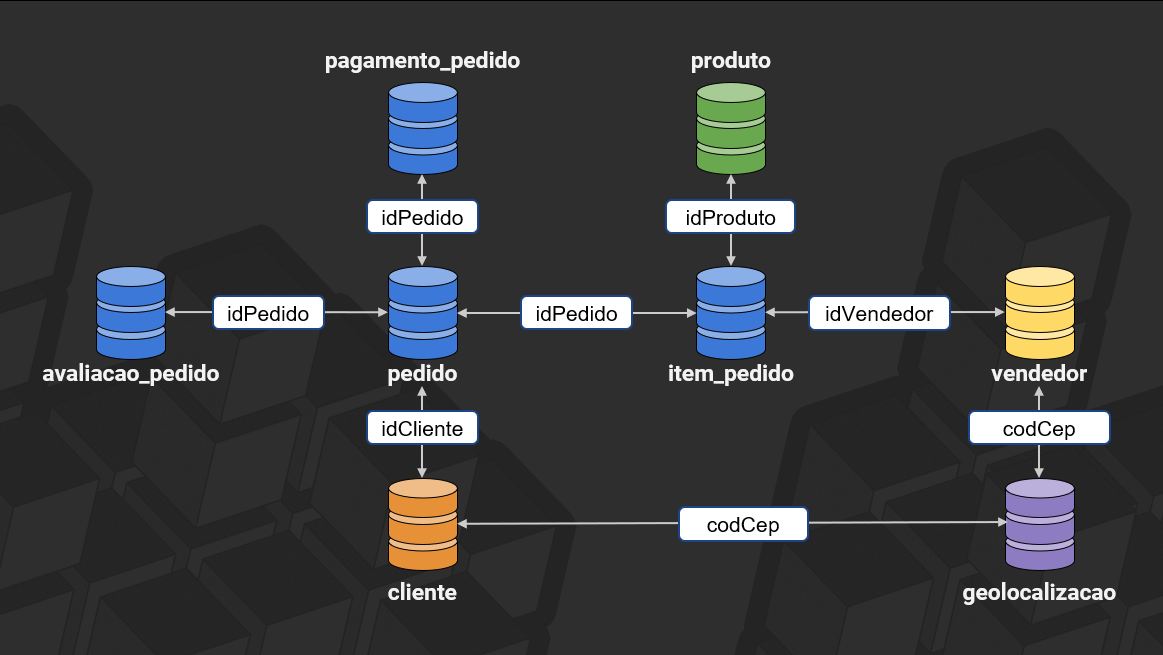

In [3]:
import pandas as pd 
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
from sqlalchemy import create_engine, text

In [5]:
my_conn = create_engine('sqlite:////content/drive/MyDrive/ML + Teo/data/olist.db')

In [6]:
# Get a connection from the engine
conn = my_conn.connect()

# Definição de variáveis

Variáveis de avaliação

- Avaliação média em NPS

- Nota media da avaliação

- quantidade de avaliações

- quantidade de avaliações negativas

Variáveis de vendas

- Qtd de vendas

- Qtd de vendas / dia

- Qtd de vendas (pedidos)

- Qtd de bedas Itens

- LTV

- Dias sem vender

- ticket médio

- Intervalo medio entre vendas

- dias desde a primeira venda 

- valor medio por produto

- maior valor de produto 

- maior valor de venda

- menor valor de produto

- menor valor de venda

- media valor de venda

- media valor de produto

- Media de itens por pedido

Variáveis de produto

- categorias de produto vendidas

- Tamanho do portfolio (qtd de itens distintos) 

- tamanho do produto por volume

- media quantidade de fotos por produto

Variaveis de clientes

- Regiões para onde vende

Variáveis de entrega

- % de entregas com atraso

- valor de frete (media ou mediana)

- tempo médio de entrega

- Pedidos cancelados

- diferença entre promessa em entrega (dias)

Variáveis pagamento

- forma de pagamento (%) okok

- Qtd media de parcelas 

#Divisão pagamento

In [10]:
# qual a nossa range de tempo
query = """
SELECT max(DATE(dtPedido)), 
min(DATE(dtPedido)), 
count(*)

      from pedido
;
"""
result = conn.execute(text(query)).fetchall()

result

[('2018-10-17', '2016-09-04', 99441)]

##Bora timee

In [70]:
def cria_view (querycriaview = str, nome_tabela = str):
  'cria uma view, mas antes deleta se ela não existe'

  dropnatabela = f"DROP VIEW IF EXISTS {nome_tabela};"
  with conn.execute(text(dropnatabela)):
    pass
  with conn.execute(text(querycriaview)):
    pass
  

In [69]:
# selecionando nossa range de análise
query = """
create view tb_pagamento as
SELECT t3.idVendedor,
      t2.descTipoPagamento,
      count(distinct (t2.idPedido)) as qtdePedidoMeioPagamento,
      sum(t2.vlPagamento) as vlPedidoMeioPagamento
       
from pedido as t1

      left join pagamento_pedido as t2
      on t1.idPedido = t2.idPedido

      left join item_pedido as t3
      on t1.idPedido = t3.idPedido

where t1.dtPedido < '2018-01-01' -- 6 meses para frente
      and t1.dtPedido >= '2017-07-01'
      and t3.idVendedor is not Null

group by idVendedor, descTipoPagamento
order by idVendedor, descTipoPagamento
      
;
"""
cria_view(query, 'tb_pagamento')


In [85]:
# selecionando nossa range de análise
query = """
SELECT  idVendedor,

sum (case when descTipoPagamento = 'credit_card' then 
    qtdePedidoMeioPagamento else 0 end) as qtde_boleto,
sum (case when descTipoPagamento = 'boleto' then 
    qtdePedidoMeioPagamento else 0 end) as qtde_credit_card,
sum (case when descTipoPagamento = 'debit_card' then 
    qtdePedidoMeioPagamento else 0 end) as qtde_voucher,
sum (case when descTipoPagamento = 'voucher' then 
    qtdePedidoMeioPagamento else 0 end) as qtde_debit_card,


sum (case when descTipoPagamento = 'credit_card' then 
    qtdePedidoMeioPagamento else 0 end) / sum(qtdePedidoMeioPagamento) 
        as pct_qtde_boleto,
sum (case when descTipoPagamento = 'boleto' then 
    qtdePedidoMeioPagamento else 0 end) / sum(qtdePedidoMeioPagamento) 
        as pct_qtde_credit_card,
sum (case when descTipoPagamento = 'debit_card' then 
    qtdePedidoMeioPagamento else 0 end) / sum(qtdePedidoMeioPagamento) 
        as pct_qtde_voucher,
sum (case when descTipoPagamento = 'voucher' then 
    qtdePedidoMeioPagamento else 0 end) / sum(qtdePedidoMeioPagamento) 
        as pct_qtde_debit_card,


sum (case when descTipoPagamento = 'credit_card' then 
    vlPedidoMeioPagamento else 0 end) as valor_boleto,
sum (case when descTipoPagamento = 'boleto' then 
    vlPedidoMeioPagamento else 0 end) as valor_credit_card,
sum (case when descTipoPagamento = 'debit_card' then 
    vlPedidoMeioPagamento else 0 end) as valor_voucher,
sum (case when descTipoPagamento = 'voucher' then 
    vlPedidoMeioPagamento else 0 end) as valor_debit_card,


sum (case when descTipoPagamento = 'credit_card' then 
    vlPedidoMeioPagamento else 0 end)/sum(vlPedidoMeioPagamento)  
        as pct_valor_boleto,
sum (case when descTipoPagamento = 'boleto' then 
    vlPedidoMeioPagamento else 0 end)/sum(vlPedidoMeioPagamento)  
        as pct_valor_credit_card,
sum (case when descTipoPagamento = 'debit_card' then 
    vlPedidoMeioPagamento else 0 end) /sum(vlPedidoMeioPagamento)  
        as pct_valor_voucher,
sum (case when descTipoPagamento = 'voucher' then 
    vlPedidoMeioPagamento else 0 end) /sum(vlPedidoMeioPagamento) 
        as pct_valor_debit_card


from tb_pagamento

group by 1
      
;"""
result_teste = conn.execute(text(query)).fetchall()

df_teste = pd.DataFrame(result_teste)

In [81]:
result_teste[0]

('0015a82c2db000af6aaaf3ae2ecb0532', 3, 0, 0, 0, 2748.06005859375, 0, 0, 0)

In [84]:
df_teste

,idVendedor,qtde_boleto,qtde_credit_card,qtde_voucher,qtde_debit_card,pct_qtde_boleto,pct_qtde_credit_card,pct_qtde_voucher,pct_qtde_debit_card,valor_boleto,valor_credit_card,valor_voucher,valor_debit_card,pct_valor_boleto,pct_valor_credit_card,pct_valor_voucher,pct_valor_debit_card
0,0015a82c2db000af6aaaf3ae2ecb0532,3,0,0,0,1,0,0,0,2748.060059,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
1,001cca7ae9ae17fb1caed9dfb1094831,77,18,2,1,0,0,0,0,17118.230057,4355.220062,264.160004,140.080002,0.782451,0.199071,0.012074,0.006403
2,002100f778ceb8431b7a1020ff7ab48f,21,16,0,5,0,0,0,0,776.630000,788.489998,0.000000,139.680000,0.455555,0.462512,0.000000,0.081933
3,003554e2dce176b5555353e4f3555ac8,1,0,0,0,1,0,0,0,139.380005,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
4,004c9cd9d87a3c30c522c48c4fc07416,63,18,0,4,0,0,0,0,8974.290012,2405.229996,0.000000,445.029998,0.758954,0.203410,0.000000,0.037636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1479,ff69aa92bb6b1bf9b8b7a51c2ed9cf8b,3,1,0,0,0,0,0,0,3007.140015,1028.619995,0.000000,0.000000,0.745124,0.254876,0.000000,0.000000
1480,ff82e8873fba613f2261a9acc896fd84,1,0,0,0,1,0,0,0,31.010000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
1481,ffdd9f82b9a447f6f8d4b91554cc7dd3,4,2,0,0,0,0,0,0,1742.029991,200.790001,0.000000,0.000000,0.896650,0.103350,0.000000,0.000000
1482,ffeee66ac5d5a62fe688b9d26f83f534,7,2,0,0,0,0,0,0,1191.159973,328.519989,0.000000,0.000000,0.783823,0.216177,0.000000,0.000000


3026

In [86]:
spark.stop()

São tabelas:

pedido

pagamento_pedido

produto

cliente

geolocalizacao

item_pedido

avaliacao_pedido

vendedor